# INIT

In [17]:
import numpy as np
from abc import ABC, abstractmethod
from sklearn.datasets import load_iris
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import os
from dataclasses import dataclass, field

# DATA

## BaseEnv

In [18]:
class BaseEnv(ABC):
  @abstractmethod
  def __init__(self, *args, **kwargs):
    pass

  @abstractmethod
  def get_sample(self, *args, **kwargs) -> np.ndarray:
    pass

  @abstractmethod
  def check(self, *args, **kwargs) -> int:
    pass

  @abstractmethod
  def get_params(self, *args, **kwargs) -> dict:
    pass

## IrisEnv

In [19]:
class IrisEnv(BaseEnv):
  def __init__(self):
    self.data = load_iris()
    self.indexes = np.arange(self.data.data.shape[0])
    self.n_arms = len(np.unique(self.data.target))

  def get_sample(self):
    random_idx = int(np.random.choice(self.indexes))
    current_context = self.data.data[random_idx]
    self.current_target = self.data.target[random_idx]
    return current_context.squeeze()

  def check(self, arm):
    reward = 1 if (arm == self.current_target) else 0
    return reward

  def get_params(self):
    params = {
        "dim": len(self.data.data[0]),
        "n_arms": self.n_arms,
    }
    return params

# BANDITS

## BaseBandit

In [21]:
class BaseBandit(ABC):
  @abstractmethod
  def __init__(self, n_arms: int, *args, **kwargs):
    self.n_arms = n_arms

  @abstractmethod
  def select_arm(self, *args, **kwargs) -> int:
    pass

  @abstractmethod
  def update(self, context: np.ndarray, arm: int, reward: float, *args, **kwargs):
    pass

  @abstractmethod
  def get_name(self):
    pass

## EpsilonGreedy

In [22]:
class EpsilonGreedy(BaseBandit):
  def __init__(self, n_arms:int, epsilon: float = 0.1, *args, **kwargs):
    super().__init__(n_arms)
    self.epsilon = epsilon

    self.q_values = np.zeros(self.n_arms)
    self.count_q_arms = np.zeros(self.n_arms)

  def select_arm(self, *args, **kwargs) -> int:
    if np.random.random() < self.epsilon:
      return np.random.randint(self.n_arms)
    return np.argmax(self.q_values)

  def update(self, arm, reward, *args, **kwargs):
    self.count_q_arms[arm] += 1
    self.q_values[arm] += (reward - self.q_values[arm]) / self.count_q_arms[arm]

  def get_name(self):
    return f"EpsilonGreedy(epsilon={self.epsilon})"

## UCB2

In [23]:
class UCB2(BaseBandit):
  def __init__(self, n_arms:int, alpha: float=0.1, *args, **kwargs):
    super().__init__(n_arms)
    self.alpha = alpha

    self.q_values = np.zeros(self.n_arms)
    self.count_q_arms = np.zeros(self.n_arms)
    self.total_steps = 0

  def select_arm(self, *args, **kwargs) -> int:
    best_ucb = -float("inf")
    for arm in range(self.n_arms):
      if self.count_q_arms[arm] == 0:
        return arm
      ucb_arm = self.q_values[arm] + np.sqrt(2 * (1+ self.alpha) * np.log(self.total_steps+1) / self.count_q_arms[arm])
      if ucb_arm > best_ucb:
        best_ucb = ucb_arm
        best_arm = arm
    return best_arm

  def update(self, arm, reward, *args, **kwargs):
    self.count_q_arms[arm] += 1
    self.q_values[arm] += (reward - self.q_values[arm]) / self.count_q_arms[arm]

  def get_name(self):
    return f"UCB2(alpha={self.alpha})"

## UCB

In [24]:
class UCB(UCB2):
  def __init__(self, n_arms:int, *args, **kwargs):
    super().__init__(n_arms, alpha=0)

  def get_name(self):
    return f"UCB"

## LinUCB

In [26]:
class ClassicLinUCB(BaseBandit):
  def __init__(self, n_arms: int, dim: int, alpha: int = 1, *args, **kwargs):
    super().__init__(n_arms)
    self.dim = dim
    self.alpha = alpha

    self.A = [np.eye(self.dim) for _ in range(self.n_arms)]
    self.b = [np.zeros(self.dim) for _ in range(self.n_arms)]

  def select_arm(self, context) -> int:
    best_ucb = -float("inf")
    for arm in range(self.n_arms):
      inverse_A = np.linalg.inv(self.A[arm])
      theta_a = inverse_A @ self.b[arm]

      ucb_arm = theta_a @ context + self.alpha * np.sqrt(context @ inverse_A @ context)
      if ucb_arm > best_ucb:
        best_ucb = ucb_arm
        best_arm = arm
    return best_arm

  def update(self, context, arm, reward):
    context = np.expand_dims(context, axis=1)
    self.A[arm] += context @ context.T
    self.b[arm] += reward * context.squeeze()

  def get_name(self):
    return f"LinUCB(alpha={self.alpha})"


## LinUCB (Sherman-Morrison Optimized)

In [28]:
class LinUCB(BaseBandit):
  def __init__(self, n_arms: int, dim: int, alpha: int = 1, *args, **kwargs):
    super().__init__(n_arms)
    self.dim = dim
    self.alpha = alpha

    self.A = [np.eye(self.dim) for _ in range(self.n_arms)]
    self.b = [np.zeros(self.dim) for _ in range(self.n_arms)]
    self.A_inv = [np.eye(self.dim) for _ in range(self.n_arms)]

  def select_arm(self, context: np.ndarray) -> int:
    best_ucb = -float("inf")
    for arm in range(self.n_arms):
      theta_a = self.A_inv[arm] @ self.b[arm]

      ucb_arm = theta_a @ context + self.alpha * np.sqrt(context @ self.A_inv[arm] @ context)
      if ucb_arm > best_ucb:
        best_ucb = ucb_arm
        best_arm = arm
    return best_arm

  def update(self, context, arm, reward):
    context = np.expand_dims(context, axis=1)
    self.A[arm] += context @ context.T
    self.b[arm] += reward * context.squeeze()
    self.A_inv[arm] -= (self.A_inv[arm] @ (context @ context.T) @ self.A_inv[arm]) / (1 + context.T @ self.A_inv[arm] @ context)

  def get_name(self):
    return f"LinUCB(alpha={self.alpha})"


## LinUCB OHE arms

In [29]:
class LinUCBoheARMS(BaseBandit):
  def __init__(self, n_arms: int, dim: int, alpha: int = 1, *args, **kwargs):
    super().__init__(n_arms)
    self.dim = dim + self.n_arms
    self.alpha = alpha

    self.A = [np.eye(self.dim) for _ in range(self.n_arms)]
    self.b = [np.zeros(self.dim) for _ in range(self.n_arms)]
    self.A_inv = [np.eye(self.dim) for _ in range(self.n_arms)]

  def select_arm(self, context: np.ndarray) -> int:
    best_ucb = -float("inf")
    for arm in range(self.n_arms):
      theta_a = self.A_inv[arm] @ self.b[arm]

      ohe_arm = np.zeros(self.n_arms)
      ohe_arm[arm] = 1
      expanded_context = np.concatenate([context, ohe_arm])

      ucb_arm = theta_a @ expanded_context + self.alpha * np.sqrt(expanded_context @ self.A_inv[arm] @ expanded_context)
      if ucb_arm > best_ucb:
        best_ucb = ucb_arm
        best_arm = arm
    return best_arm

  def update(self, context, arm, reward):
    ohe_arm = np.zeros(self.n_arms)
    ohe_arm[arm] = 1
    expanded_context = np.concatenate([context, ohe_arm])

    context = np.expand_dims(expanded_context, axis=1)
    self.A[arm] += context @ context.T
    self.A_inv[arm] -= (self.A_inv[arm] @ (context @ context.T) @ self.A_inv[arm]) / (1 + context.T @ self.A_inv[arm] @ context)
    self.b[arm] += reward * context.squeeze()

  def get_name(self):
    return f"LinUCBoheARMS(alpha={self.alpha})"

## Adaptive LinUCB

In [30]:
class AdaptiveLinUCB(LinUCB):
  def __init__(self, n_arms: int, dim: int, alpha: float = 1, *args, **kwargs):
    super().__init__(n_arms, dim, alpha)
    self.first_alpha = self.alpha
    self.total_steps = 0

  def update(self, context, arm, reward):
    super().update(context, arm, reward)
    self.total_steps += 1
    self.alpha = self.first_alpha / np.log(self.total_steps + 2)

  def get_name(self):
    return f"AdaptiveLinUCB(alpha={self.first_alpha})"

## DecayingAlpha LinUCB

In [31]:
class DecayingAlphaLinUCB(LinUCB):
  def __init__(self, n_arms: int, dim: int, alpha: float = 1, beta=0.99, *args, **kwargs):
    super().__init__(n_arms, dim, alpha)
    self.first_alpha = self.alpha
    self.beta = beta
    self.total_steps = 0

  def update(self, context, arm, reward):
    super().update(context, arm, reward)
    self.alpha *= self.beta

  def get_name(self):
    return f"DecayingAlphaLinUCB(alpha={self.first_alpha}, beta={self.beta})"

# UTILS

In [34]:
def check_path(path, make=False):
  if not make:
    return os.path.isfile(path)
  if not os.path.exists(path):
    try:
      os.makedirs(path)
    except OSError as e:
      print(f"Ошибка при создании директории {path}: {e}")

In [35]:
def save_pickle(data, path, filename):
  check_path(path, make=True)
  with open(os.path.join(path, filename), 'wb') as f:
    pickle.dump(data, f)

In [36]:
def open_pickle(path):
  file_exist = check_path(path)
  if not file_exist:
    print(f"Файл {path} не существует")
  with open(path, 'rb') as f:
    loaded_data = pickle.load(f)
  return loaded_data

In [37]:
class MwP: # ModelWithParams
  def __init__(self, model: BaseBandit, **kwargs):
    self.model = model
    self.params = kwargs

# LAUNCH

In [38]:
class Launching:
  def __init__(self,
               n_episodes: int,
               models: list,
               env: BaseEnv,
               random_seed: int = 19,
               save_results: bool = False,
               plotting: bool = False,
               path_to_save: str = "/expirements/",
               ):
    self.models = models
    self.env = env

    self.seed = random_seed
    self.n_episodes = n_episodes

    self.save_results = save_results
    self.plotting = plotting
    self.path_to_save = path_to_save

  def run(self, model):
    reward_history = []
    regret_history = []
    regret = 0

    for episode in tqdm(range(self.n_episodes)):
      sample = self.env.get_sample()
      arm = model.select_arm(sample)
      reward = self.env.check(arm)
      model.update(context=sample, arm=arm, reward=reward)

      regret += 1 - reward
      regret_history.append(regret)

      reward_history.append(reward)

    if self.plotting:
      plt.plot(regret_history, label=model.get_name())
      plt.title("Regret; " + self.env.__class__.__name__)

    if self.save_results:
      save_data = {
          "regret_history": regret_history,
          "reward_history": reward_history,
      }
      save_pickle(save_data, self.path_to_save, model.get_name())


  def launch(self):
    if self.plotting:
      plt.figure(figsize=(12, 6))

    for model in self.models:
      np.random.seed(self.seed)
      current_params = model.params
      current_params.update(self.env.get_params())
      current_model = model.model(**current_params)

      print(current_model.get_name())

      self.run(current_model)

    if self.plotting:
      plt.legend()


In [53]:
algs = [
      MwP(EpsilonGreedy, epsilon=0.41),
      MwP(UCB),
      MwP(UCB2, alpha=0.5),
      MwP(DecayingAlphaLinUCB, alpha=0.41, beta=0.99),
      MwP(LinUCBoheARMS, alpha=0.41),
      MwP(LinUCB, alpha=0.41),
      MwP(AdaptiveLinUCB, alpha=0.41),
]
process = Launching(
    n_episodes=1000,
    models = algs,
    env = IrisEnv(),
    plotting = True,
)

EpsilonGreedy(epsilon=0.41)


100%|██████████| 1000/1000 [00:00<00:00, 35790.02it/s]


UCB


100%|██████████| 1000/1000 [00:00<00:00, 24682.69it/s]


UCB2(alpha=0.5)


100%|██████████| 1000/1000 [00:00<00:00, 32025.90it/s]


DecayingAlphaLinUCB(alpha=0.41, beta=0.99)


100%|██████████| 1000/1000 [00:00<00:00, 8339.90it/s]


LinUCBoheARMS(alpha=0.41)


100%|██████████| 1000/1000 [00:00<00:00, 6788.77it/s]


LinUCB(alpha=0.41)


100%|██████████| 1000/1000 [00:00<00:00, 8290.09it/s]


AdaptiveLinUCB(alpha=0.41)


100%|██████████| 1000/1000 [00:00<00:00, 8947.92it/s]


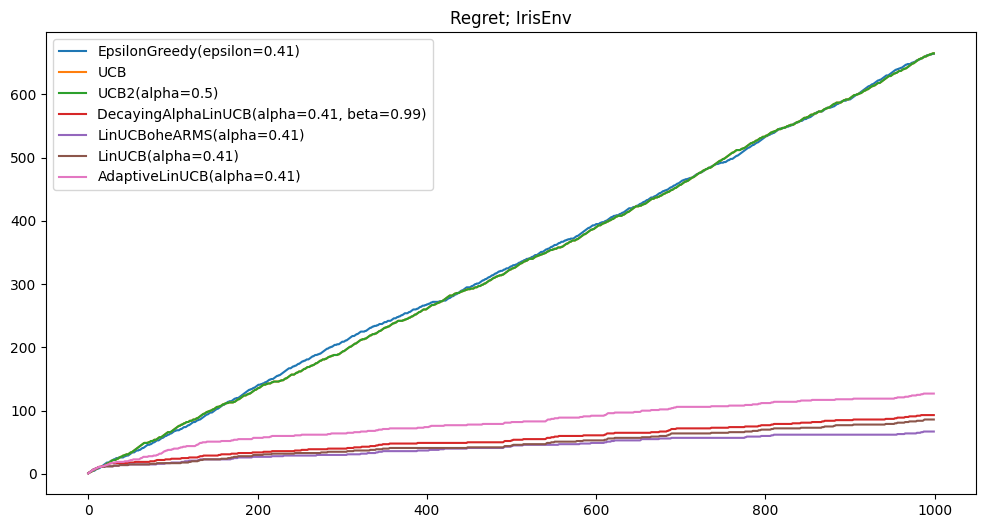

In [54]:
process.launch()